## IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split ,KFold
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler





In [2]:
df=pd.read_csv('../data/processed/data_processed.csv')

## MODELING

### ***FIRST CASE: STUDY OF MACHINE FAILURE PREDICTION:***

We divide the set in X and y (target):

In [ ]:
X=df.drop(['Product ID','Machine failure','TWF','HDF','PWF','OSF','Power [W]','Disipation'],axis=1)
y=df['Machine failure']

In [ ]:
X.head(5)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M
UDI,,,,,,,,
1,298.1,308.6,1551,42.8,0,False,False,True
2,298.2,308.7,1408,46.3,3,False,True,False
3,298.1,308.5,1498,49.4,5,False,True,False
4,298.2,308.6,1433,39.5,7,False,True,False
5,298.2,308.7,1408,40.0,9,False,True,False


We divide the set in train and test:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 8)
(2000, 8)
(8000,)
(2000,)


In [ ]:
X_train.to_csv('../data/train/X_train.csv')

In [ ]:
y_train.to_csv('../data/train/y_train.csv')

In [ ]:
X_test.to_csv('../data/test/X_test.csv')

In [ ]:
y_test.to_csv('../data/test/y_test.csv')

Since we have a large number of 1s compared to 0s, we will try performing an under-sampling and over-sampling to see if it improves the results.

In [ ]:
oversampler = RandomOverSampler(random_state=42)
X_over_resampled, y_over_resampled = oversampler.fit_resample(X_train, y_train)

X_over_resampled.shape,y_over_resampled.shape

((15458, 8), (15458,))

In [ ]:
X_over_resampled.to_csv('../data/train/X_train_over.csv')

In [ ]:
y_over_resampled.to_csv('../data/train/y_train_over.csv')

In [ ]:
undersampler = RandomUnderSampler(random_state=42)
X_under_resampled, y_under_resampled = undersampler.fit_resample(X_train, y_train)

X_under_resampled.shape,y_under_resampled.shape

((542, 8), (542,))

In [ ]:
X_under_resampled.to_csv('./data/train/X_train_under.csv')

In [ ]:
y_under_resampled.to_csv('./data/train/y_train_under.csv')

Let's see what we would obtain by considering the entire sample with cross-validation and the logistic regression model to get an idea of the ROC AUC values we will be working with.

In [ ]:
results=cross_val_score(LogisticRegression(max_iter=10000),X,y,scoring='roc_auc',cv=10)
results

array([0.97549434, 0.88268786, 0.86511996, 0.83254171, 0.85202777,
       0.83433808, 0.85498112, 0.94257703, 0.91943734, 0.9107904 ])

To find the best model, we will apply a pipeline where we set a series of steps to select the best features, the type of standardization, and the model type. For this, we will focus on grid search with recall, so that the model is better adjusted to predict when the machine will fail, without worrying too much about potential errors in prediction (partially yes, as it could affect production time to change it multiple times).

In [ ]:
pipe = Pipeline(steps=[("selectkbest", SelectKBest()),
    ("scaler", StandardScaler()),
    ('classifier', svm.SVC())
])

random_forest_params = {
    'selectkbest__k': [3,4,5,'all'],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [RandomForestClassifier(random_state=100)],
    'classifier__max_depth': [2,3,4]
}

svm_param = {
    'selectkbest__k': [3,4,5,'all'],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [svm.SVC(probability=True, random_state=42)],
    'classifier__C': [ 1, 5, 10, 100],
}


search_space = [
    random_forest_params,
    svm_param,
]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = KFold(10),
                  scoring='recall',
                  verbose=2,
                  n_jobs=-1)


In [ ]:
clf.fit(X_train, y_train)
model=clf.best_estimator_
model

Fitting 10 folds for each of 84 candidates, totalling 840 fits


Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('scaler', StandardScaler()),
                ('classifier', SVC(C=100, probability=True, random_state=42))])

In [ ]:
predictions=model.predict(X_test)
predictions_proba_normal = model.predict_proba(X_test)

In [ ]:
pd.DataFrame(index=['accuracy','precision','recall','confusion_matrix','roc_auc'],columns=['results_model'],data=[accuracy_score(y_test, predictions),precision_score(y_test, predictions),recall_score(y_test, predictions),confusion_matrix(y_test,predictions),roc_auc_score(y_test, predictions)])

,results_model
accuracy,0.9785
precision,0.727273
recall,0.588235
confusion_matrix,"[[1917, 15], [28, 40]]"
roc_auc,0.790236


In [ ]:
skbest = model.named_steps["selectkbest"]
selected_indices = skbest.get_support(indices=True)
feature_names = X.columns[selected_indices]
print(feature_names)
scores = skbest.scores_  # # Puntuations of all the features
print(scores[selected_indices])  # Only selected


Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_H',
       'Type_L', 'Type_M'],
      dtype='object')
[ 59.59532468  13.36805799  12.79574813 299.65269077  79.51017358
   4.94597239  17.827876     9.38729859]


#### UNDERSAMPLER:

In [ ]:
clf.fit(X_under_resampled, y_under_resampled)
model_under_resampled=clf.best_estimator_
model_under_resampled

Fitting 10 folds for each of 84 candidates, totalling 840 fits


Pipeline(steps=[('selectkbest', SelectKBest(k=3)), ('scaler', StandardScaler()),
                ('classifier', SVC(C=10, probability=True, random_state=42))])

In [ ]:
predictions_under=model_under_resampled.predict(X_test)
predictions_proba_under = model_under_resampled.predict_proba(X_test)

In [ ]:
pd.DataFrame(index=['accuracy','precision','recall','confusion_matrix','roc_auc'],columns=['results_model'],data=[accuracy_score(y_test, predictions_under),precision_score(y_test, predictions_under),recall_score(y_test, predictions_under),confusion_matrix(y_test,predictions_under),roc_auc_score(y_test, predictions_under)])

,results_model
accuracy,0.858
precision,0.187861
recall,0.955882
confusion_matrix,"[[1651, 281], [3, 65]]"
roc_auc,0.905219


In [ ]:
skbest = model_under_resampled.named_steps["selectkbest"]
selected_indices = skbest.get_support(indices=True)
feature_names = X.columns[selected_indices]
print(feature_names)
scores = skbest.scores_  # Puntuations of all the features
print(scores[selected_indices])  # Only selected


Index(['Air temperature [K]', 'Torque [Nm]', 'Tool wear [min]'], dtype='object')
[25.2595668  74.83333703 35.62649038]


#### OVERSAMPLER:

In [ ]:
clf.fit(X_over_resampled, y_over_resampled)
model_over_resampled=clf.best_estimator_
model_over_resampled

Fitting 10 folds for each of 84 candidates, totalling 840 fits


Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('scaler', StandardScaler()),
                ('classifier', SVC(C=100, probability=True, random_state=42))])

En este caso se han elegido todas las features por parte del SKBest y se han ajustado unos pesos estadísitcos.

In [ ]:
predictions_over=model_over_resampled.predict(X_test)
predictions_proba_over = model_over_resampled.predict_proba(X_test)

In [ ]:
pd.DataFrame(index=['accuracy','precision','recall','confusion_matrix','roc_auc'],columns=['results_model'],data=[accuracy_score(y_test, predictions_over),precision_score(y_test, predictions_over),recall_score(y_test, predictions_over),confusion_matrix(y_test,predictions_over),roc_auc_score(y_test, predictions_over)])

,results_model
accuracy,0.9425
precision,0.357576
recall,0.867647
confusion_matrix,"[[1826, 106], [9, 59]]"
roc_auc,0.906391


In [ ]:
skbest = model_over_resampled.named_steps["selectkbest"]
selected_indices = skbest.get_support(indices=True)
feature_names = X.columns[selected_indices]
print(feature_names)
scores = skbest.scores_  # Puntuations of all the features
print(scores[selected_indices])  # Only selected


Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_H',
       'Type_L', 'Type_M'],
      dtype='object')
[ 770.77300379  171.99814681   73.9359058  2396.89330349  968.54957939
   74.91000652  313.49720875  187.1290987 ]


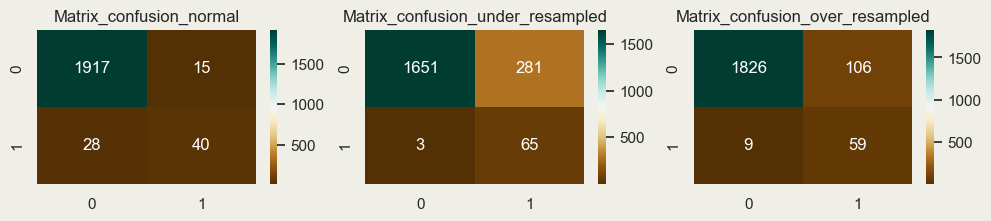

In [ ]:
plt.figure(figsize=(12,2))
plt.subplot(1,3,1)
plt.title('Matrix_confusion_normal')
sns.heatmap(confusion_matrix(y_test,predictions),cmap='BrBG', annot=True,fmt='.0f',);
plt.subplot(1,3,2)
plt.title('Matrix_confusion_under_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_under),cmap='BrBG', annot=True,fmt='.0f',);
plt.subplot(1,3,3)
plt.title('Matrix_confusion_over_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_over),cmap='BrBG', annot=True,fmt='.0f',);

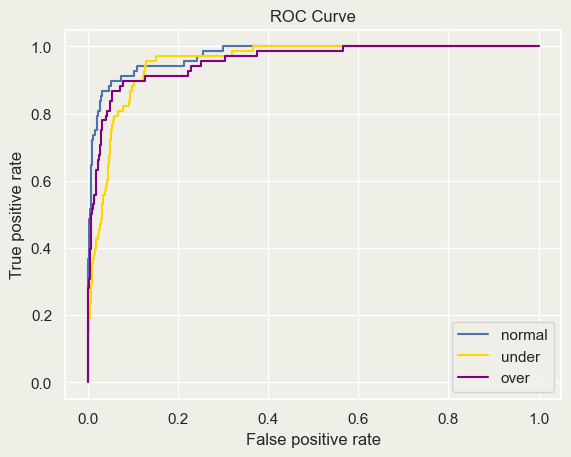

In [ ]:
""" 
Roc curve normal data
"""
y_pred_prob = model.predict_proba(X_test)
np.round(y_pred_prob, 2)
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob[:,1])

#Plot the roc curve
plt.plot(fpr,tpr,label='normal')

""" 
Roc curve under resampled
"""

y_pred_prob_under = model_under_resampled.predict_proba(X_test)
np.round(y_pred_prob_under, 2)
fpr_u, tpr_u, threshold_u = roc_curve(y_test, y_pred_prob_under[:,1])

#Plot the roc curve
plt.plot(fpr_u,tpr_u,label='under',color='gold')

""" 
Roc curve over resampled
"""

y_pred_prob_over = model_over_resampled.predict_proba(X_test)
np.round(y_pred_prob_over, 2)
fpr_o, tpr_o, threshold = roc_curve(y_test, y_pred_prob_over[:,1])

#Plot the roc curve
plt.plot(fpr_o,tpr_o,label='over',color='purple')



plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.legend();

#### PCA Models

We also check by applying PCA to see if this dimensionality reduction technique generalizes better:

In [ ]:
pipe2 = Pipeline(steps=[("pca", PCA()),
    ("scaler", StandardScaler()),
    ('classifier', svm.SVC())
])

random_forest_params2 = {
    'pca__n_components': [3,4,5,None],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [RandomForestClassifier(random_state=100)],
    'classifier__max_depth': [2,3,4]
}

svm_param2 = {
    'pca__n_components': [3,4,5,None],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [svm.SVC(probability=True, random_state=42)],
    'classifier__C': [ 1, 5, 10, 100]
}

search_space2 = [
    random_forest_params2,
    svm_param2
]

clf2 = GridSearchCV(estimator = pipe2,
                  param_grid = search_space2,
                  cv = KFold(10),
                  scoring='recall',
                  verbose=2,
                  n_jobs=-1)


In [ ]:
clf2.fit(X_train, y_train)
model2=clf2.best_estimator_
model2

Fitting 10 folds for each of 84 candidates, totalling 840 fits


Pipeline(steps=[('pca', PCA()), ('scaler', StandardScaler()),
                ('classifier', SVC(C=100, probability=True, random_state=42))])

In [ ]:
predictions2=model2.predict(X_test)


In [ ]:
clf2.fit(X_under_resampled, y_under_resampled)
model_under_resampled2=clf2.best_estimator_
model_under_resampled2

Fitting 10 folds for each of 84 candidates, totalling 840 fits


Pipeline(steps=[('pca', PCA(n_components=4)), ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=4, random_state=100))])

In [ ]:
predictions_under2=model_under_resampled2.predict(X_test)


In [ ]:
clf2.fit(X_over_resampled, y_over_resampled)
model_over_resampled2=clf2.best_estimator_
model_over_resampled2

Fitting 10 folds for each of 84 candidates, totalling 840 fits


Pipeline(steps=[('pca', PCA()), ('scaler', StandardScaler()),
                ('classifier', SVC(C=100, probability=True, random_state=42))])

For both the case without resampling and the over-resampled case, the best results are obtained without applying PCA.

In [ ]:
predictions_over2=model_over_resampled2.predict(X_test)


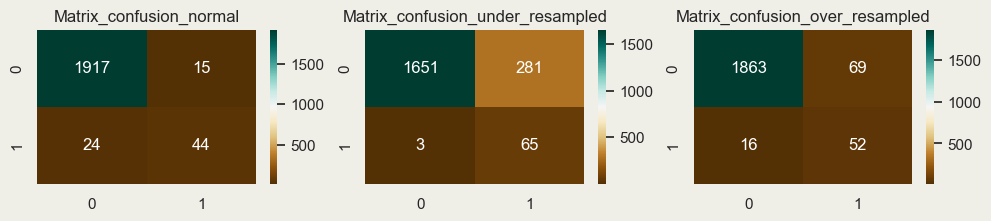

In [ ]:
plt.figure(figsize=(12,2))
plt.subplot(1,3,1)
plt.title('Matrix_confusion_normal')
sns.heatmap(confusion_matrix(y_test,predictions2),cmap='BrBG', annot=True,fmt='.0f',);
plt.subplot(1,3,2)
plt.title('Matrix_confusion_under_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_under2),cmap='BrBG', annot=True,fmt='.0f',);
plt.subplot(1,3,3)
plt.title('Matrix_confusion_over_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_over2),cmap='BrBG', annot=True,fmt='.0f',);

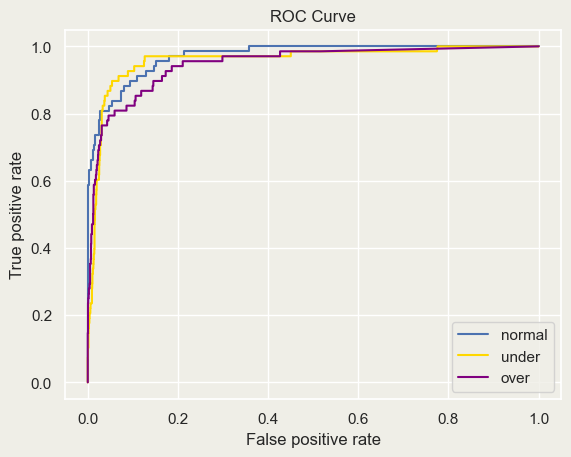

In [ ]:
""" 
Roc curve normal data
"""
y_pred_prob2 = model2.predict_proba(X_test)
np.round(y_pred_prob2, 2)
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob2[:,1])

#Plot the roc curve
plt.plot(fpr,tpr,label='normal')

""" 
Roc curve under resampled
"""

y_pred_prob_under2 = model_under_resampled2.predict_proba(X_test)
np.round(y_pred_prob_under2, 2)
fpr_u, tpr_u, threshold_u = roc_curve(y_test, y_pred_prob_under2[:,1])

#Plot the roc curve
plt.plot(fpr_u,tpr_u,label='under',color='gold')

""" 
Roc curve over resampled
"""

y_pred_prob_over2 = model_over_resampled2.predict_proba(X_test)
np.round(y_pred_prob_over2, 2)
fpr_o, tpr_o, threshold = roc_curve(y_test, y_pred_prob_over2[:,1])

#Plot the roc curve
plt.plot(fpr_o,tpr_o,label='over',color='purple')



plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.legend();

### STATISTICS OF THE SIX MODELS:

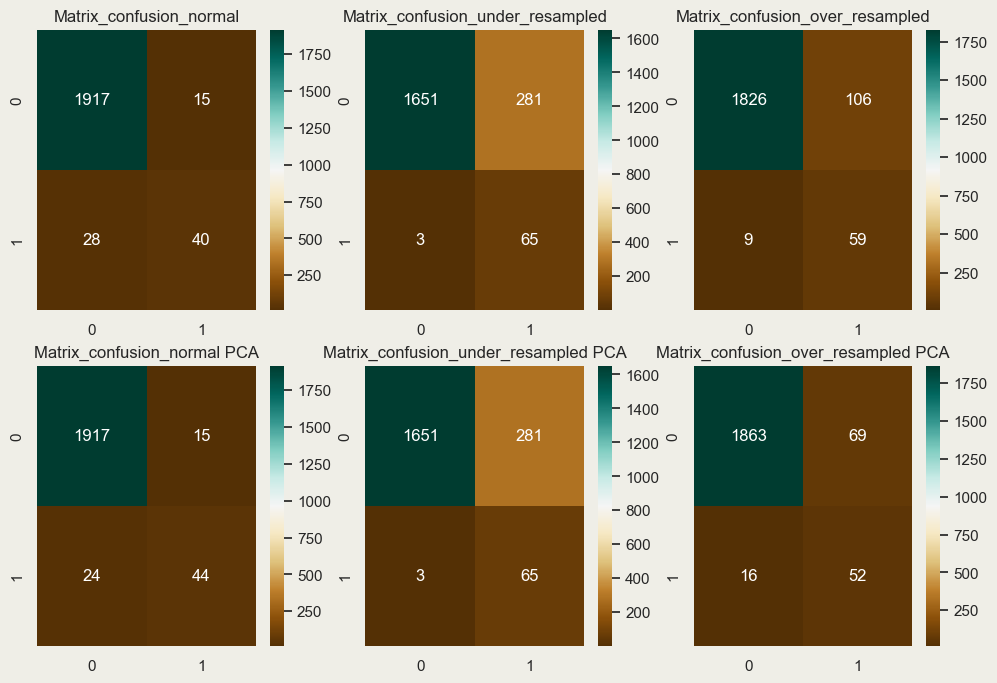

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.title('Matrix_confusion_normal')
sns.heatmap(confusion_matrix(y_test,predictions),cmap='BrBG', annot=True,fmt='.0f',);
plt.subplot(2,3,2)
plt.title('Matrix_confusion_under_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_under),cmap='BrBG', annot=True,fmt='.0f',);
plt.subplot(2,3,3)
plt.title('Matrix_confusion_over_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_over),cmap='BrBG', annot=True,fmt='.0f',);
plt.subplot(2,3,4)
plt.title('Matrix_confusion_normal PCA')
sns.heatmap(confusion_matrix(y_test,predictions2),cmap='BrBG', annot=True,fmt='.0f',);
plt.subplot(2,3,5)
plt.title('Matrix_confusion_under_resampled PCA')
sns.heatmap(confusion_matrix(y_test,predictions_under2),cmap='BrBG', annot=True,fmt='.0f',);
plt.subplot(2,3,6)
plt.title('Matrix_confusion_over_resampled PCA')
sns.heatmap(confusion_matrix(y_test,predictions_over2),cmap='BrBG', annot=True,fmt='.0f',);

And below are the metrics for the two over-resampled models, which have provided the best results:

In [ ]:
print(classification_report(y_test, predictions_over))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1932
           1       0.36      0.87      0.51        68

    accuracy                           0.94      2000
   macro avg       0.68      0.91      0.74      2000
weighted avg       0.97      0.94      0.95      2000



In [ ]:
print(classification_report(y_test, predictions_over2))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1932
           1       0.43      0.76      0.55        68

    accuracy                           0.96      2000
   macro avg       0.71      0.86      0.76      2000
weighted avg       0.97      0.96      0.96      2000



Since the results of both models are not very different from each other, although it seems that the model with PCA slightly favors precision over recall, and the other model does the opposite, we will finally decide by performing cross-validations of ROC AUC, recall, and precision.

In [ ]:
results_sk=cross_val_score(model_over_resampled,X_test,y_test,scoring='roc_auc',cv=10)
results_pca=cross_val_score(model_over_resampled2,X_test,y_test,scoring='roc_auc',cv=10)

results_sk.mean(), results_pca.mean()

(np.float64(0.9434449726688389), np.float64(0.9470546826711027))

In [ ]:
results_sk=cross_val_score(model_over_resampled,X_test,y_test,scoring='recall',cv=10)
results_pca=cross_val_score(model_over_resampled2,X_test,y_test,scoring='recall',cv=10)

results_sk.mean(), results_pca.mean()

(np.float64(0.5738095238095238), np.float64(0.4976190476190475))

In [ ]:
results_sk=cross_val_score(model_over_resampled,X_test,y_test,scoring='precision',cv=10)
results_pca=cross_val_score(model_over_resampled2,X_test,y_test,scoring='precision',cv=10)

results_sk.mean(), results_pca.mean()

(np.float64(0.7466666666666667), np.float64(0.5774206349206349))

After observing all the metrics, we will opt for the model that applies SelectKBest, as it gives better results both in recall for the value 1, which is the most important, and in the cross-validations performed.

For illustrative purposes, we see how the models adapt to our entire dataset (train + test).

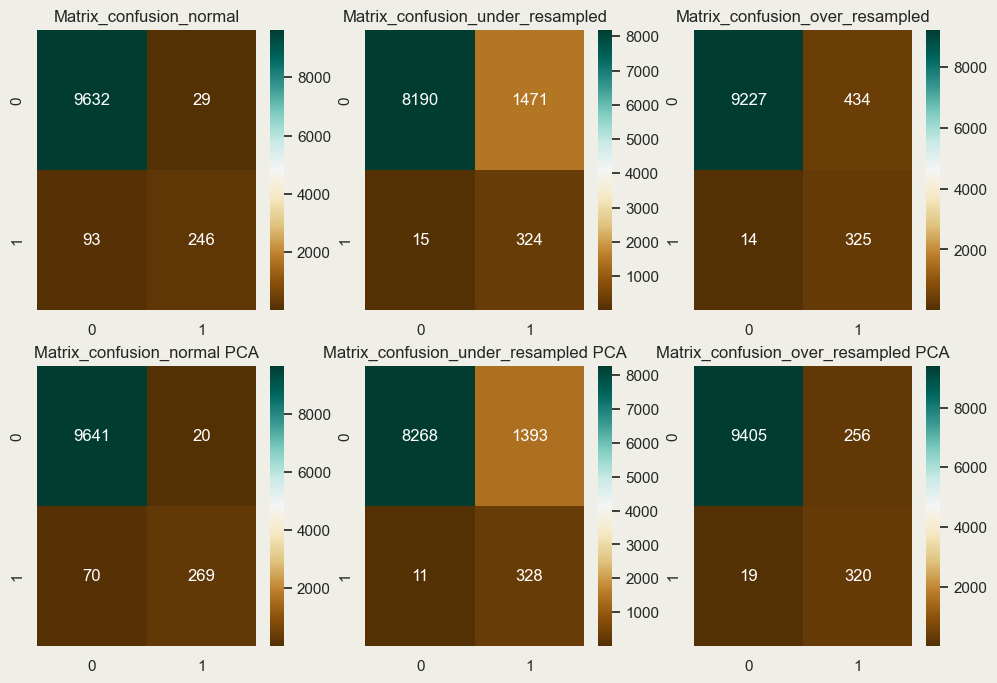

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.title('Matrix_confusion_normal')
sns.heatmap(confusion_matrix(y,model.predict(X)),cmap='BrBG', annot=True,fmt='.0f');
plt.subplot(2,3,2)
plt.title('Matrix_confusion_under_resampled')
sns.heatmap(confusion_matrix(y,model_under_resampled.predict(X),),cmap='BrBG', annot=True,fmt='.0f');
plt.subplot(2,3,3)
plt.title('Matrix_confusion_over_resampled')
sns.heatmap(confusion_matrix(y,model_over_resampled.predict(X)),cmap='BrBG', annot=True,fmt='.0f');
plt.subplot(2,3,4)
plt.title('Matrix_confusion_normal PCA')
sns.heatmap(confusion_matrix(y,model2.predict(X)),cmap='BrBG', annot=True,fmt='.0f');
plt.subplot(2,3,5)
plt.title('Matrix_confusion_under_resampled PCA')
sns.heatmap(confusion_matrix(y,model_under_resampled2.predict(X)),cmap='BrBG', annot=True,fmt='.0f');
plt.subplot(2,3,6)
plt.title('Matrix_confusion_over_resampled PCA')
sns.heatmap(confusion_matrix(y,model_over_resampled2.predict(X)),cmap='BrBG', annot=True,fmt='.0f');

Percentage-wise:

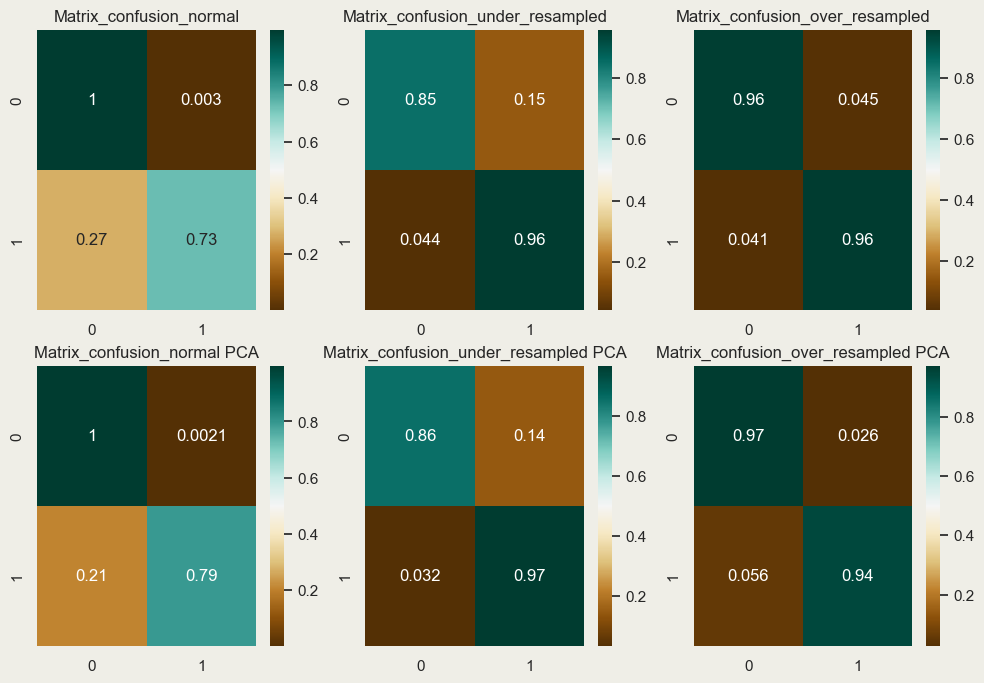

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.title('Matrix_confusion_normal')
sns.heatmap(confusion_matrix(y,model.predict(X),normalize='true'),cmap='BrBG', annot=True);
plt.subplot(2,3,2)
plt.title('Matrix_confusion_under_resampled')
sns.heatmap(confusion_matrix(y,model_under_resampled.predict(X),normalize='true'),cmap='BrBG', annot=True,);
plt.subplot(2,3,3)
plt.title('Matrix_confusion_over_resampled')
sns.heatmap(confusion_matrix(y,model_over_resampled.predict(X),normalize='true'),cmap='BrBG', annot=True);
plt.subplot(2,3,4)
plt.title('Matrix_confusion_normal PCA')
sns.heatmap(confusion_matrix(y,model2.predict(X),normalize='true'),cmap='BrBG', annot=True);
plt.subplot(2,3,5)
plt.title('Matrix_confusion_under_resampled PCA')
sns.heatmap(confusion_matrix(y,model_under_resampled2.predict(X),normalize='true'),cmap='BrBG', annot=True);
plt.subplot(2,3,6)
plt.title('Matrix_confusion_over_resampled PCA')
sns.heatmap(confusion_matrix(y,model_over_resampled2.predict(X),normalize='true'),cmap='BrBG', annot=True);

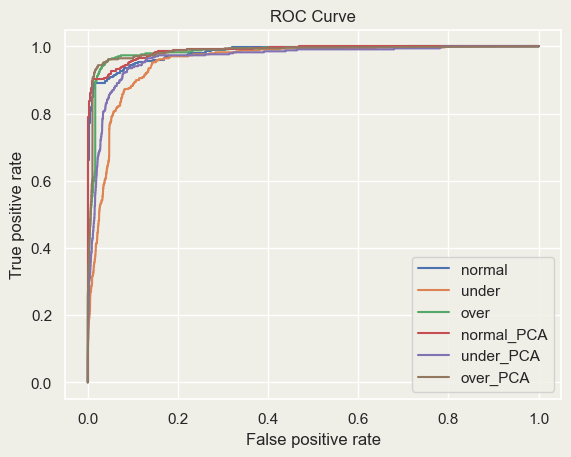

In [ ]:
""" 
Roc curve normal data
"""
y_pred_prob = model.predict_proba(X)
np.round(y_pred_prob, 2)
fpr, tpr, threshold = roc_curve(y, y_pred_prob[:,1])

#Plot the roc curve
plt.plot(fpr,tpr,label='normal')

""" 
Roc curve under resampled
"""

y_pred_prob_under = model_under_resampled.predict_proba(X)
np.round(y_pred_prob_under, 2)
fpr_u, tpr_u, threshold_u = roc_curve(y, y_pred_prob_under[:,1])

#Plot the roc curve
plt.plot(fpr_u,tpr_u,label='under')

""" 
Roc curve over resampled
"""

y_pred_prob_over = model_over_resampled.predict_proba(X)
np.round(y_pred_prob_over, 2)
fpr_o, tpr_o, threshold = roc_curve(y, y_pred_prob_over[:,1])

#Plot the roc curve
plt.plot(fpr_o,tpr_o,label='over')


""" 
Roc curve normal data
"""
y_pred_prob2 = model2.predict_proba(X)
np.round(y_pred_prob2, 2)
fpr, tpr, threshold = roc_curve(y, y_pred_prob2[:,1])

#Plot the roc curve
plt.plot(fpr,tpr,label='normal_PCA')

""" 
Roc curve under resampled
"""

y_pred_prob_under2 = model_under_resampled2.predict_proba(X)
np.round(y_pred_prob_under2, 2)
fpr_u, tpr_u, threshold_u = roc_curve(y, y_pred_prob_under2[:,1])

#Plot the roc curve
plt.plot(fpr_u,tpr_u,label='under_PCA')

""" 
Roc curve over resampled
"""

y_pred_prob_over2 = model_over_resampled2.predict_proba(X)
np.round(y_pred_prob_over2, 2)
fpr_o, tpr_o, threshold = roc_curve(y, y_pred_prob_over2[:,1])

#Plot the roc curve
plt.plot(fpr_o,tpr_o,label='over_PCA')



plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.legend();

### ****CONCLUSION:****

In contrast to the non-rebalanced model, the balanced models do not predict the 0s (correct operation) as well, as they sometimes classify them as having a high likelihood of failure (1). However, they tend to predict the 1s with a high degree of accuracy. What matters most? In an initial economic context, the second case seems more favorable, as although we may have to stop the machine more frequently, we would save on broken tools. However, this may significantly affect processing time, leading to a decrease in production. The oversampled models provide a middle ground between the non-rebalanced model and the under-sampled one. Any of these two models would be valid, but the one selected is the one that applies SelectKBest, based on the cross-validation results that allowed us to make a better decision.

In [ ]:
model_over_resampled

Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('scaler', StandardScaler()),
                ('classifier', SVC(C=100, probability=True, random_state=42))])

#### Save the models:

In [ ]:
import pickle

filename = './models/model_normal.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(model, archivo_salida)

In [ ]:

filename = './models/model_under.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(model_under_resampled, archivo_salida)

In [ ]:

filename = './models/model_over.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(model_over_resampled, archivo_salida)

In [ ]:

filename = './models/model_normal_pca.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(model2, archivo_salida)

In [ ]:

filename = './models/model_under_pca.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(model_under_resampled2, archivo_salida)

In [ ]:

filename = './models/model_over_pca.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(model_over_resampled2, archivo_salida)

### ***SECOND CASE: STUDY OF FAILURE TYPE PREDICTION:***


We will keep the dataframe where only failures have occurred, as it will be with this dataset that we predict the type of failure.

In [ ]:
df_type=df[df['Machine failure']==1]

In [ ]:
df_type.to_csv('df_type')

In [ ]:
df_type.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339 entries, 51 to 9975
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               339 non-null    object 
 1   Air temperature [K]      339 non-null    float64
 2   Process temperature [K]  339 non-null    float64
 3   Rotational speed [rpm]   339 non-null    int64  
 4   Torque [Nm]              339 non-null    float64
 5   Tool wear [min]          339 non-null    int64  
 6   Power [W]                339 non-null    float64
 7   Disipation               339 non-null    float64
 8   Type_H                   339 non-null    bool   
 9   Type_L                   339 non-null    bool   
 10  Type_M                   339 non-null    bool   
 11  Machine failure          339 non-null    int64  
 12  TWF                      339 non-null    int64  
 13  HDF                      339 non-null    int64  
 14  PWF                      339 

In [ ]:
df_type.head()

,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Power [W],Disipation,Type_H,Type_L,Type_M,Machine failure,TWF,HDF,PWF,OSF
UDI,,,,,,,,,,,,,,,,
51,L47230,298.9,309.1,2861,4.6,143,1378.174809,10.2,False,True,False,1,0,0,1,0
70,L47249,298.9,309.0,1410,65.7,191,9700.923955,10.1,False,True,False,1,0,0,1,1
78,L47257,298.8,308.9,1455,41.3,208,6292.767165,10.1,False,True,False,1,1,0,0,0
161,L47340,298.4,308.2,1282,60.7,216,8149.019072,9.8,False,True,False,1,0,0,0,1
162,L47341,298.3,308.1,1412,52.3,218,7733.302588,9.8,False,True,False,1,0,0,0,1


#### IMPORT SPECIFIC LIBRARIES

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Define input and output variables
X_t = df_type.drop(columns=['TWF', 'HDF', 'PWF', 'OSF', 'Machine failure','Disipation','Power [W]', 'Product ID'])  # Features
y_t = df_type[['TWF', 'HDF', 'PWF', 'OSF']]  # labels

In [ ]:
X_t.head(2)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M
UDI,,,,,,,,
51,298.9,309.1,2861,4.6,143,False,True,False
70,298.9,309.0,1410,65.7,191,False,True,False


In [ ]:
y_t.head(2)

,TWF,HDF,PWF,OSF
UDI,,,,
51,0,0,1,0
70,0,0,1,1


In [ ]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.2, random_state=42)

In [ ]:
X_train.to_csv('../data/train/X_train_keras.csv')

In [ ]:
y_train.to_csv('../data/train/y_train_keras.csv')

In [ ]:
X_test.to_csv('../data/test/X_test_keras.csv')

In [ ]:
y_test.to_csv('../data/test/y_test_keras.csv')

In [ ]:
# Normalize data
scaler = StandardScaler()
X_t_scaled = scaler.fit_transform(X_t)

In [ ]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_t_scaled, y_t, test_size=0.2, random_state=42)

In [ ]:
# Build the model in Keras
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(4, activation='sigmoid')  # 4 outputs for multi-label classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],

              )

In [ ]:
earlystopping = keras.callbacks.EarlyStopping(patience=5)

In [ ]:
# Train the model
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.2 ,
                    callbacks = [earlystopping]
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3698 - loss: 0.6872 - val_accuracy: 0.3636 - val_loss: 0.6444
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4535 - loss: 0.6165 - val_accuracy: 0.4727 - val_loss: 0.5934
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4640 - loss: 0.5623 - val_accuracy: 0.6000 - val_loss: 0.5471
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4872 - loss: 0.5082 - val_accuracy: 0.5455 - val_loss: 0.5106
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5626 - loss: 0.4628 - val_accuracy: 0.6182 - val_loss: 0.4725
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7021 - loss: 0.4178 - val_accuracy: 0.6182 - val_loss: 0.4296
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6864 - loss: 0.3767 - val_accuracy: 0.6364 - val_loss: 0.3900
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7758 - loss: 0.3126 - val_accuracy: 0.6364 

<Axes: >

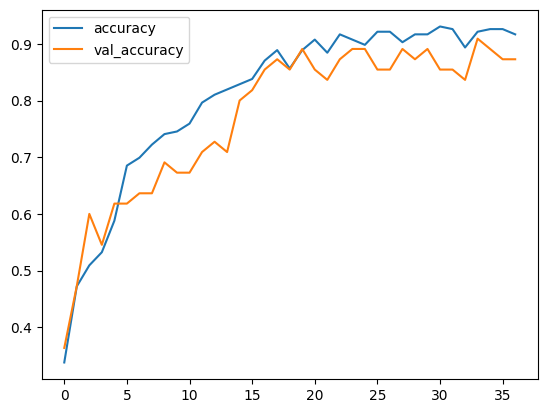

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()

In [ ]:
# Predicitons
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [ ]:
np.round(y_pred,2)

array([[0.  , 0.  , 0.03, 1.  ],
       [0.06, 0.95, 0.  , 0.  ],
       [0.01, 0.56, 0.03, 0.77],
       [0.95, 0.01, 0.  , 0.04],
       [0.  , 1.  , 0.  , 0.  ],
       [0.01, 0.12, 0.09, 0.94],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.01, 0.15, 0.99],
       [0.92, 0.01, 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.04, 0.6 , 0.02, 0.37],
       [0.  , 0.03, 0.3 , 0.97],
       [0.01, 0.92, 0.02, 0.04],
       [0.  , 1.  , 0.01, 0.  ],
       [0.  , 0.5 , 0.14, 0.5 ],
       [0.  , 1.  , 0.01, 0.  ],
       [0.  , 0.02, 0.01, 1.  ],
       [0.18, 0.03, 0.12, 0.  ],
       [0.  , 0.02, 0.01, 1.  ],
       [0.98, 0.  , 0.  , 0.  ],
       [0.86, 0.  , 0.03, 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.99, 0.08, 0.  ],
       [0.01, 0.97, 0.01, 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.98, 0.03, 0.  ],
       [0.11, 0.87, 0.  , 0.01],
       [0.  , 0.99, 0.01, 0.  ],
       [0.33, 0.01, 0.  , 0.66],
       [0.

In [ ]:
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels
y_pred_binary


array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0,

In [ ]:
# Evaluation
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        15
           1       0.80      0.95      0.87        21
           2       0.92      0.92      0.92        12
           3       0.95      0.87      0.91        23

   micro avg       0.90      0.86      0.88        71
   macro avg       0.92      0.85      0.87        71
weighted avg       0.91      0.86      0.88        71
 samples avg       0.87      0.85      0.85        71



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vamos a realizar una matriz de confusión para ver los resultados más claramente:


In [ ]:
y_test_lista=np.array(y_test.values)

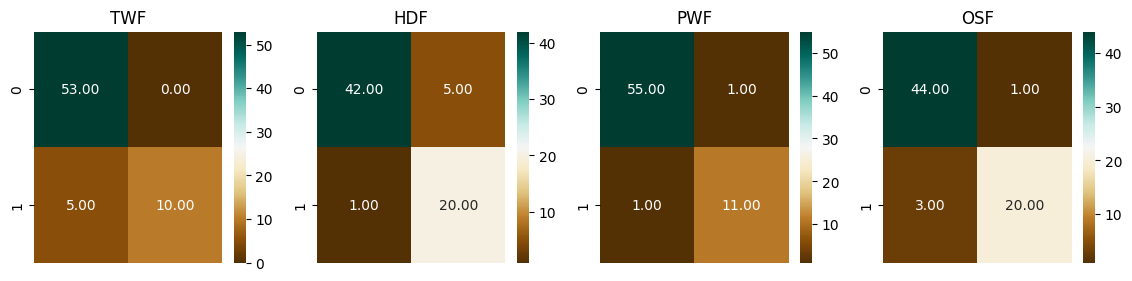

In [ ]:
plt.figure(figsize=(14,3))
title_data=['TWF', 'HDF', 'PWF', 'OSF']

for i in range(y_pred_binary.shape[1]):
  y_pred_binary_clas=list()
  y_test_lista_clas=list()
  for j in range(y_pred_binary.shape[0]):
    if y_pred_binary[j][i]==1:
      y_pred_binary_clas.append(1)
    else:
      y_pred_binary_clas.append(0)
    if y_test_lista[j][i]==1:
      y_test_lista_clas.append(1)
    else:
      y_test_lista_clas.append(0)
  #plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.subplot(1,4,i+1)
  sns.heatmap(confusion_matrix(y_test_lista_clas, y_pred_binary_clas), annot=True, cmap='BrBG', fmt=".2f")
  plt.xticks([])
  plt.title(title_data[i],fontsize=12)

In [ ]:
X_t.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_H',
       'Type_L', 'Type_M'],
      dtype='object')

In [ ]:
input_data = np.array([298.9, 309.1, 2861, 4.6, 143, 0, 1, 0])
input_data = np.expand_dims(input_data, axis=0)  # Reshape (1, 8)

In [ ]:
model.predict(scaler.transform(input_data))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[1.8072053e-07, 1.2597404e-07, 9.9988246e-01, 2.0209663e-10]],
      dtype=float32)

In [ ]:
model.save('model_types.keras')

In [ ]:
import pickle

filename = 'scaler.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(scaler, archivo_salida)